<a href="https://colab.research.google.com/github/dasarisowjanya980/CODSOFT/blob/main/Copy_of_minorproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMPORTING REQUIRED MODULES/LIBRARIES

In [ ]:
!pip install -q imageio
!pip install -q opencv-python

In [ ]:

#TensorFlow or TF-Hub modules
!pip install tensorflow_docs
from absl import logging

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow_docs.vis import embed

logging.set_verbosity(logging.ERROR)

#some modules that help with reading UCF101 dataset

import random
import re
import os
import tempfile
import ssl
import cv2
import numpy as np
#some modules to display an animation using imageio
import imageio
from IPython import display
from urllib import request #requires python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.5/182.5 kB 3.9 MB/s eta 0:00:00


## Helper function for the ucf 101 dataset


In [ ]:
#utilities to fetch from ucf101 dataset
UCF_ROOT = "https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/"
_VIDEO_LIST = None
_CACHE_DIR = tempfile.mkdtemp()
unverified_context = ssl._create_unverified_context()

def list_ucf_videos():
    global _VIDEO_LIST
    if not _VIDEO_LIST:
        index = request.urlopen(UCF_ROOT, context=unverified_context).read().decode("utf-8")
        videos = re.findall(r"(v_[\w_]+\.avi)", index)
        _VIDEO_LIST = sorted(set(videos))
    return list(_VIDEO_LIST)



In [ ]:
def fetch_ucf_video(video):
    cache_path = os.path.join(_CACHE_DIR, video)
    if not os.path.exists(cache_path):
        urlpath = request.urljoin(UCF_ROOT, video)
        print(f"Fetching {urlpath} => {cache_path}")
        data = request.urlopen(urlpath, context=unverified_context).read()
        open(cache_path, "wb").write(data)
    return cache_path


In [ ]:
def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y:start_y + min_dim, start_x:start_x + min_dim]


In [ ]:
def load_video(path, max_frames=0, resize=(224, 224)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames) / 255.0


In [ ]:
def to_gif(images):
    converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
    imageio.mimsave('./animation.gif', converted_images, fps=25)
    return display.Image(filename='./animation.gif')

# **Get** **the** ***kinetics*** **400** **labels**

In [ ]:
from urllib import request



KINETICS_URL="http://raw.githubusercontent.com/deepmind/kinetics-i3d/master/data/label_map.txt"
with request.urlopen(KINETICS_URL) as obj:
  labels=[line.decode("utf-8").strip() for line in obj.readlines()]
print("Found in total %d labels"%len(labels))

Found in total 400 labels


# **Get UCF101 Dataset**

In [ ]:
ucf_videos = list_ucf_videos()
categories = {}


for video in ucf_videos:
    category = video[2:-12]
    if category not in categories:
        categories[category] = []
    categories[category].append(video)

print("Found in total %d videos in overall %d categories" % (len(ucf_videos), len(categories)))

print("\n")
head1 = "Category"
head2 = "No of Videos"
head3 = "Details"
print(" %-20s %-10s %s" % (head1, head2, head3))

for category, sequences in categories.items():
    summary = ",".join(sequences[:2])
    print("%-20s %4d         %s,..." % (category, len(sequences), summary))


Found in total 13320 videos in overall 101 categories


 Category             No of Videos Details
ApplyEyeMakeup        145         v_ApplyEyeMakeup_g01_c01.avi,v_ApplyEyeMakeup_g01_c02.avi,...
ApplyLipstick         114         v_ApplyLipstick_g01_c01.avi,v_ApplyLipstick_g01_c02.avi,...
Archery               145         v_Archery_g01_c01.avi,v_Archery_g01_c02.avi,...
BabyCrawling          132         v_BabyCrawling_g01_c01.avi,v_BabyCrawling_g01_c02.avi,...
BalanceBeam           108         v_BalanceBeam_g01_c01.avi,v_BalanceBeam_g01_c02.avi,...
BandMarching          155         v_BandMarching_g01_c01.avi,v_BandMarching_g01_c02.avi,...
BaseballPitch         150         v_BaseballPitch_g01_c01.avi,v_BaseballPitch_g01_c02.avi,...
BasketballDunk        131         v_BasketballDunk_g01_c01.avi,v_BasketballDunk_g01_c02.avi,...
Basketball            134         v_Basketball_g01_c01.avi,v_Basketball_g01_c02.avi,...
BenchPress            160         v_BenchPress_g01_c01.avi,v_BenchPress_g01_c

# **Fetch a Random Video**

In [ ]:
video_path=fetch_ucf_video("v_BabyCrawling_g01_c01.avi")
sample_video=load_video(video_path)
sample_video1=load_video(video_path)[:100]
sample_video.shape

Fetching https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/v_BabyCrawling_g01_c01.avi => /tmp/tmpx6klbund/v_BabyCrawling_g01_c01.avi


(165, 224, 224, 3)

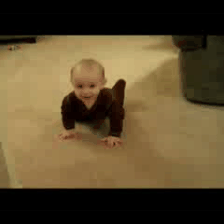

In [ ]:
to_gif(sample_video1)

In [ ]:
i3d=hub.load("https://tfhub.dev/deepmind/i3d-kinetics-400/1").signatures['default']

# **Predict from Video**

In [ ]:
import tensorflow as tf
import numpy as np

def predict(sample_video):
    model_input = tf.constant(sample_video, dtype=tf.float32)[tf.newaxis, ...]
    logits = i3d(model_input)['default'][0]
    probabilities = tf.nn.softmax(logits)
    top_indices = np.argsort(probabilities)[::-1][:5]

    # Check if all probabilities in top 5 are less than 20%
    all_invalid = all(probabilities[i] * 100 < 20 for i in top_indices)

    if all_invalid:
        print("INVALID")
    else:
        print("Top 5 actions:")
        for i in top_indices:
                print(f" {labels[i]:22}: {probabilities[i] * 100:.2f}%")



In [ ]:
predict(sample_video)

Top 5 actions:
 crawling baby         : 99.99%
 laughing              : 0.01%
 shaking head          : 0.00%
 pushing car           : 0.00%
 baby waking up        : 0.00%


In [ ]:
video_path=fetch_ucf_video("/content/non human action.avi")
sample_video=load_video(video_path)
sample_video1=load_video(video_path)[:100]
sample_video.shape

(901, 224, 224, 3)

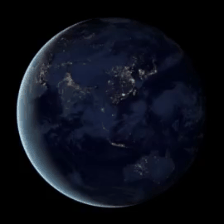

In [ ]:
to_gif(sample_video1)

In [ ]:
predict(sample_video)

INVALID
